In [1184]:
import pandas as pd
from datetime import datetime
import re

In [1185]:

records = []

file_path = "baseline_24-11-3.txt"
with open(file_path, "r") as f:
    for line in f:
        print(line)
        if "manager" in line:
            records.append(line)


custom_swim  | ------------------ VNC environment started ------------------

custom_swim  | 

custom_swim  | VNCSERVER started on DISPLAY= :1 

custom_swim  | 	=> connect via VNC viewer with 172.19.0.2:5901

custom_swim  | 

custom_swim  | noVNC HTML client started:

custom_swim  | 	=> connect via http://172.19.0.2:6901/?password=...

custom_swim  | 

custom_swim  | 

custom_swim  | 

custom_swim  | ------------------ EXECUTE COMMAND ------------------

custom_swim  | Executing command: '/bin/sh -c ./run.sh sim 1'

custom_swim  | ../../src//swim swim.ini -u Cmdenv -c sim -n ..:../../src/:../../../queueinglib:../../src -lqueueinglib -s --cmdenv-redirect-output=true -r 1

custom_swim  | sim run 1: $trace="traces/scenario.delta", $latency=0, $repetition=0

custom_swim  | t=0 addServer() complete

custom_swim  | t=0 addServer() complete

custom_swim  | t=0 addServer() complete

manager      | 2025-10-24 16:28:59,184 - INFO - Connected to swim in custom_swim:4242

manager      | 2025-10-24

In [1186]:
records

['manager      | 2025-10-24 16:28:59,184 - INFO - Connected to swim in custom_swim:4242\n',
 'manager      | 2025-10-24 16:28:59,186 - INFO - Iniciando loop de adaptação automática...\n',
 "manager      | 2025-10-24 16:28:59,186 - INFO - KB Metrics: Knowledge(ADAPTATION_GOALS={'threshold_response_time': 0.1}, History=[{}], Constraints={'dimmer'= [0.0, 1.0], 'servers'= [1, 10], 'add_server'= {'active_servers'= 'servers'}, 'remove_server'= {'active_servers'= 'servers'}}), Last_update={'active_servers': 3, 'arrival_rate': 49.9348, 'basic_rt': 0.0257791, 'basic_throughput': 5.6101, 'dimmer': 0.9, 'opt_rt': 0.391567, 'opt_throughput': 25.2426, 'servers': 3, 'activating_server': False, 'server_ult': {'server_1_ult': '0.00289597', 'server_2_ult': '0.00277821', 'server_3_ult': '0.00282813'}})\n",
 'manager      | 2025-10-24 16:28:59,187 - INFO - RT=0.03s | Active servers=3 | Dimmer=0.90 | arrival=49.89 req/s | Total servers=3\n',
 'manager      | 2025-10-24 16:28:59,187 - INFO - Diagnosis: dec

In [1187]:
def parse_logs(logs):
    parsed_data = []
    base_time = None
    
    for log in logs:
        # Pular logs que não contêm métricas (apenas linhas com "RT=")
        if "RT=" not in log:                
            continue
            
        # Extrair timestamp
        timestamp_str = log.split(' - INFO - ')[0].split('| ')[1].strip()
        
        # Converter para datetime object
        current_time = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")
        
        # Definir base_time como o primeiro timestamp encontrado
        if base_time is None:
            base_time = current_time
        
        # Calcular tempo relativo em segundos
        time_delta = current_time - base_time
        relative_time = time_delta.total_seconds()
        
        # Dividir a linha usando o padrão de separadores
        parts = log.split(' - INFO - ')[1].split(' | ')
        
        data = {'time_relative': relative_time}
        
        for part in parts:
            # Response Time
            if part.startswith('RT='):
                data['response_time'] = float(part.replace('RT=', '').replace('s', '').strip())
            
            # Active Servers
            elif part.startswith('Active servers='):
                data['active_servers'] = int(part.split('=')[1])
            
            # Dimmer
            elif part.startswith('Dimmer='):
                data['dimmer'] = float(part.split('=')[1])
            
            # Arrival Rate
            elif part.startswith('arrival='):
                data['arrival_rate'] = float(part.split('=')[1].split(' ')[0])
            
            # Total Servers
            elif part.startswith('Total servers='):
                data['total_servers'] = int(part.split('=')[1])
            
            # Diagnosis
            elif part.startswith('Diagnosis: '):
                data['diagnosis'] = part.split('Diagnosis: ')[1]
            
            # Action Plan (tratamento especial para JSON)
            elif part.startswith('Action plan: '):
                action_str = part.split('Action plan: ')[1]
                # Encontrar o início e fim do JSON
                start_idx = action_str.find('{')
                end_idx = action_str.rfind('}') + 1
                if start_idx != -1 and end_idx != 0:
                    data['action_plan'] = action_str[start_idx:end_idx]
                else:
                    data['action_plan'] = action_str
            
            # Result
            elif part.startswith('Result: '):
                data['result'] = part.split('Result: ')[1]
        
        parsed_data.append(data)
    
    return pd.DataFrame(parsed_data)

In [1188]:
def parse_diagnosis(logs):
    diagnosis = []
    inside_json = False
    json_lines = []

    for log in logs:
        if "Diagnosis:" in log:
            # Caso 1: diagnóstico simples
            if "{" not in log:
                diag = log.split("Diagnosis: ")[1].strip()
                diagnosis.append({"raw": diag})
            # Caso 2: início de JSON
            else:
                inside_json = True
                json_lines = [log.split("Diagnosis: ")[1]]
        elif inside_json:
            json_lines.append(log)
            # Detecta o final do JSON
            if "}" in log:
                inside_json = False
                json_str = "\n".join(json_lines)
                try:
                    # Remove prefixos como "manager |" antes de tentar o parse
                    cleaned = "\n".join([
                        line.split("Diagnosis: ")[-1].split("|")[-1].strip()
                        for line in json_lines
                    ])
                    diag_json = json.loads(cleaned)
                    diagnosis.append(diag_json)
                except Exception as e:
                    diagnosis.append({"raw": cleaned, "error": str(e)})

    diag_final = []

    for item in diagnosis:
        diag_final.append(str(item))

    return pd.DataFrame(diag_final)

In [1189]:
def parse_plans(logs):
    plans = []
    for log in logs:
        if "Action plan:" not in log:
            continue
        p = log.split('Action plan: ')[1]
        plans.append(p)

    return pd.DataFrame(plans)

In [1190]:
def call_humans(df):
    result_df = df.copy()
    
    mask = (
        result_df['diagnosis'].str.contains('call_human', na=False) & 
        result_df['plans'].str.contains("danger", na=False)
    )
    result_df['human_calls'] = mask
    
    return result_df

In [1191]:
df_base = parse_logs(records)

In [1192]:
df_base

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers
0,0.000,0.03,3,0.9,49.89,3
1,26.034,3.53,2,0.9,50.11,2
2,56.076,5.74,3,0.9,50.69,3
3,86.110,6.73,3,0.9,50.75,3
4,116.145,7.43,3,0.9,54.62,3
5,146.182,8.13,3,0.9,59.08,3
6,176.215,7.81,3,0.9,57.42,3
7,206.252,6.73,3,0.9,56.84,3
8,236.288,6.01,2,0.9,55.99,2
9,266.324,6.13,2,0.9,94.96,2


In [1193]:
df_base['diagnosis'] = parse_diagnosis(records)
df_base['plans'] = parse_plans(records)
df_base

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers,diagnosis,plans
0,0.000,0.03,3,0.9,49.89,3,{'raw': 'decrease_servers'},{'decrease_servers_plan': {'entry': 'decrease_...
1,26.034,3.53,2,0.9,50.11,2,{'raw': 'increase_servers'},{'increase_servers_plan': {'entry': 'increase_...
2,56.076,5.74,3,0.9,50.69,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
3,86.110,6.73,3,0.9,50.75,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
4,116.145,7.43,3,0.9,54.62,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
5,146.182,8.13,3,0.9,59.08,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
6,176.215,7.81,3,0.9,57.42,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
7,206.252,6.73,3,0.9,56.84,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
8,236.288,6.01,2,0.9,55.99,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
9,266.324,6.13,2,0.9,94.96,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n


In [1194]:
records = []

file_path = "maper_24-11-3.txt"
with open(file_path, "r") as f:
    for line in f:
        if "manager" in line:
            records.append(line)


In [1195]:
df_maper = parse_logs(records)

In [1196]:
df_maper['diagnosis'] = parse_diagnosis(records)
df_maper['plans'] = parse_plans(records)
df_maper

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers,diagnosis,plans
0,0.000,0.02,3,0.9,48.17,3,{'raw': 'decrease_servers'},{'decrease_servers_plan': {'entry': 'decrease_...
1,26.027,3.65,2,0.9,50.11,2,{'raw': 'increase_servers'},{'increase_servers_plan': {'entry': 'increase_...
2,56.059,5.97,3,0.9,50.75,3,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...
3,86.902,6.84,3,0.9,50.70,3,"{'raw': '{""recomendations"": ""consider_increasi...",{'consider_increasing_active_servers_to_meet_r...
4,116.901,7.11,4,0.9,54.80,4,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...
5,146.068,7.77,4,0.9,59.11,4,{'raw': 'call_human'},"{'call_human_plan': {'action': ['add_server'],..."
6,175.879,6.96,5,0.9,57.49,5,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...
7,206.818,6.09,4,0.9,56.84,4,{'recomendations': 'increase_servers_to_reduce...,{'increase_servers_to_reduce_response_time_pla...
8,235.852,5.39,5,0.9,56.01,5,{'recomendations': 'consider_increasing_server...,{'consider_increasing_servers_to_reduce_respon...
9,266.298,5.60,6,0.9,94.62,6,{'raw': 'call_human'},"{'call_human_plan': {'action': ['add_server'],..."


In [1197]:
df_maper = df_maper.iloc[:33, :]
df_maper

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers,diagnosis,plans
0,0.000,0.02,3,0.9,48.17,3,{'raw': 'decrease_servers'},{'decrease_servers_plan': {'entry': 'decrease_...
1,26.027,3.65,2,0.9,50.11,2,{'raw': 'increase_servers'},{'increase_servers_plan': {'entry': 'increase_...
2,56.059,5.97,3,0.9,50.75,3,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...
3,86.902,6.84,3,0.9,50.70,3,"{'raw': '{""recomendations"": ""consider_increasi...",{'consider_increasing_active_servers_to_meet_r...
4,116.901,7.11,4,0.9,54.80,4,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...
5,146.068,7.77,4,0.9,59.11,4,{'raw': 'call_human'},"{'call_human_plan': {'action': ['add_server'],..."
6,175.879,6.96,5,0.9,57.49,5,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...
7,206.818,6.09,4,0.9,56.84,4,{'recomendations': 'increase_servers_to_reduce...,{'increase_servers_to_reduce_response_time_pla...
8,235.852,5.39,5,0.9,56.01,5,{'recomendations': 'consider_increasing_server...,{'consider_increasing_servers_to_reduce_respon...
9,266.298,5.60,6,0.9,94.62,6,{'raw': 'call_human'},"{'call_human_plan': {'action': ['add_server'],..."


In [1198]:
df_base = df_base.iloc[:33, :]
df_base

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers,diagnosis,plans
0,0.000,0.03,3,0.9,49.89,3,{'raw': 'decrease_servers'},{'decrease_servers_plan': {'entry': 'decrease_...
1,26.034,3.53,2,0.9,50.11,2,{'raw': 'increase_servers'},{'increase_servers_plan': {'entry': 'increase_...
2,56.076,5.74,3,0.9,50.69,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
3,86.110,6.73,3,0.9,50.75,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
4,116.145,7.43,3,0.9,54.62,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
5,146.182,8.13,3,0.9,59.08,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
6,176.215,7.81,3,0.9,57.42,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
7,206.252,6.73,3,0.9,56.84,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
8,236.288,6.01,2,0.9,55.99,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n
9,266.324,6.13,2,0.9,94.96,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n


In [1199]:
df_maper = call_humans(df_maper)
df_maper

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers,diagnosis,plans,human_calls
0,0.000,0.02,3,0.9,48.17,3,{'raw': 'decrease_servers'},{'decrease_servers_plan': {'entry': 'decrease_...,False
1,26.027,3.65,2,0.9,50.11,2,{'raw': 'increase_servers'},{'increase_servers_plan': {'entry': 'increase_...,False
2,56.059,5.97,3,0.9,50.75,3,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...,False
3,86.902,6.84,3,0.9,50.70,3,"{'raw': '{""recomendations"": ""consider_increasi...",{'consider_increasing_active_servers_to_meet_r...,False
4,116.901,7.11,4,0.9,54.80,4,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...,False
5,146.068,7.77,4,0.9,59.11,4,{'raw': 'call_human'},"{'call_human_plan': {'action': ['add_server'],...",False
6,175.879,6.96,5,0.9,57.49,5,{'recomendations': 'increase_servers_if_respon...,{'increase_servers_if_response_time_exceeds_th...,False
7,206.818,6.09,4,0.9,56.84,4,{'recomendations': 'increase_servers_to_reduce...,{'increase_servers_to_reduce_response_time_pla...,False
8,235.852,5.39,5,0.9,56.01,5,{'recomendations': 'consider_increasing_server...,{'consider_increasing_servers_to_reduce_respon...,False
9,266.298,5.60,6,0.9,94.62,6,{'raw': 'call_human'},"{'call_human_plan': {'action': ['add_server'],...",False


In [1200]:
df_base = call_humans(df_base)
df_base

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers,diagnosis,plans,human_calls
0,0.000,0.03,3,0.9,49.89,3,{'raw': 'decrease_servers'},{'decrease_servers_plan': {'entry': 'decrease_...,False
1,26.034,3.53,2,0.9,50.11,2,{'raw': 'increase_servers'},{'increase_servers_plan': {'entry': 'increase_...,False
2,56.076,5.74,3,0.9,50.69,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True
3,86.110,6.73,3,0.9,50.75,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True
4,116.145,7.43,3,0.9,54.62,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True
5,146.182,8.13,3,0.9,59.08,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True
6,176.215,7.81,3,0.9,57.42,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True
7,206.252,6.73,3,0.9,56.84,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True
8,236.288,6.01,2,0.9,55.99,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True
9,266.324,6.13,2,0.9,94.96,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True


In [1201]:
def relative_improvement(v1, v2):
    return (v1-v2)*100/v2

In [1202]:
new_df = pd.DataFrame([{
    'metric': 'mean_rt',
    'maper': df_maper['response_time'].mean(),
    'baseline': df_base['response_time'].mean(),
    'difference':df_maper['response_time'].mean()- df_base['response_time'].mean(),
    'relative_improvement' : relative_improvement(df_base['response_time'].mean(), df_maper['response_time'].mean())
}, {
    'metric': 'mean_active_servers', 
    'maper': df_maper['active_servers'].mean(),
    'baseline': df_base['active_servers'].mean(),
    'difference':df_maper['active_servers'].mean()-df_base['active_servers'].mean(),
    'relative_improvement' : relative_improvement(df_maper['active_servers'].mean(),df_base['active_servers'].mean())
}, {
    'metric': 'mean_dimmer',
    'maper': df_maper['dimmer'].mean(),
    'baseline': df_base['dimmer'].mean(),
    'difference' : df_maper['dimmer'].mean()-df_base['dimmer'].mean(),
    'relative_improvement': relative_improvement(df_maper['dimmer'].mean(), df_base['dimmer'].mean())
}, {
        'metric':'human_calls',
        'maper' : df_maper['human_calls'].sum(),
        'baseline': df_base['human_calls'].sum(),
        'difference' : df_maper['human_calls'].sum()-df_base['human_calls'].sum(),
        'relative_improvement': "-"
}, {
    'metric':'max_rt',
    'maper' : df_maper['response_time'].max(),
    'baseline': df_base['response_time'].max(),
    'difference': df_maper['response_time'].max()-df_base['response_time'].max(),
    'relative_improvement':relative_improvement(df_base['response_time'].max(),df_maper['response_time'].max())
}, {
    'metric':'min_rt',
    'maper' : df_maper['response_time'].min(),
    'baseline': df_base['response_time'].min(),
    'difference': df_maper['response_time'].min()-df_base['response_time'].min(),
    'relative_improvement':relative_improvement(df_base['response_time'].min(),df_maper['response_time'].min())},
    {
        'metric' : 'min_servers',
        'maper' : df_maper['active_servers'].min(),
        'baseline': df_base['active_servers'].min(),
        'difference': '-',
        'relative_improvement':'-'
    },     {
        'metric' : 'max_servers',
        'maper' : df_maper['active_servers'].max(),
        'baseline': df_base['active_servers'].max(),
        'difference': '-',
        'relative_improvement':'-'
    }


])

new_df_transposed = new_df.set_index('metric').T

new_df_transposed.index.name = 'system'
new_df_transposed.to_csv('res_1.csv')
new_df_transposed

metric,mean_rt,mean_active_servers,mean_dimmer,human_calls,max_rt,min_rt,min_servers,max_servers
system,,,,,,,,
maper,5.197619,6.714286,0.9,0.0,7.77,0.02,2.0,12.0
baseline,6.411429,2.333333,0.9,19.0,8.13,0.03,2.0,3.0
difference,-1.21381,4.380952,0.0,-19,-0.36,-0.01,-,-
relative_improvement,23.353184,187.755102,0.0,-,4.633205,50.0,-,-


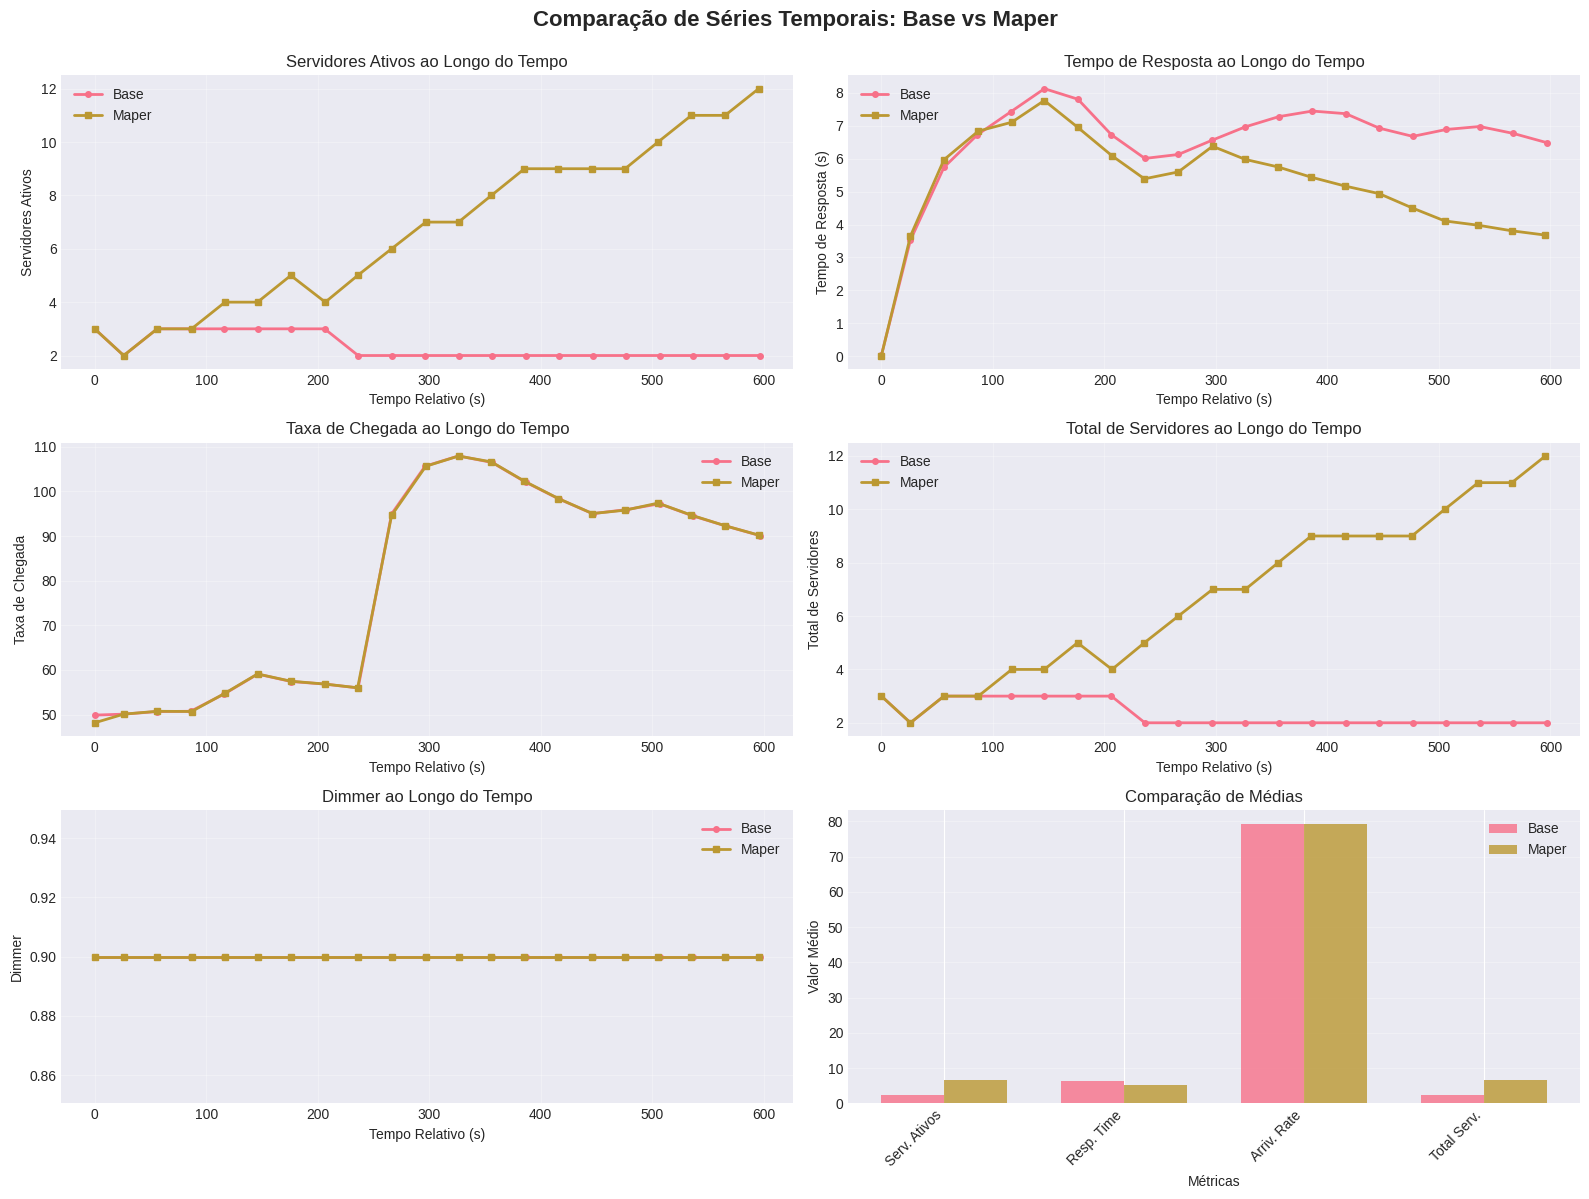

In [1203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Assumindo que você já tem os DataFrames carregados:
# df_base = pd.read_csv('base.csv')
# df_maper = pd.read_csv('maper.csv')

def comparar_series_temporais(df_base, df_maper):
    """
    Compara métricas entre duas tabelas de séries temporais
    """
    
    # Criar figura com subplots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Comparação de Séries Temporais: Base vs Maper', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # 1. Servidores Ativos
    ax1 = axes[0, 0]
    ax1.plot(df_base['time_relative'], df_base['active_servers'], 
             label='Base', marker='o', linewidth=2, markersize=4)
    ax1.plot(df_maper['time_relative'], df_maper['active_servers'], 
             label='Maper', marker='s', linewidth=2, markersize=4)
    ax1.set_xlabel('Tempo Relativo (s)')
    ax1.set_ylabel('Servidores Ativos')
    ax1.set_title('Servidores Ativos ao Longo do Tempo')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Tempo de Resposta
    ax2 = axes[0, 1]
    ax2.plot(df_base['time_relative'], df_base['response_time'], 
             label='Base', marker='o', linewidth=2, markersize=4)
    ax2.plot(df_maper['time_relative'], df_maper['response_time'], 
             label='Maper', marker='s', linewidth=2, markersize=4)
    ax2.set_xlabel('Tempo Relativo (s)')
    ax2.set_ylabel('Tempo de Resposta (s)')
    ax2.set_title('Tempo de Resposta ao Longo do Tempo')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Taxa de Chegada
    ax3 = axes[1, 0]
    ax3.plot(df_base['time_relative'], df_base['arrival_rate'], 
             label='Base', marker='o', linewidth=2, markersize=4)
    ax3.plot(df_maper['time_relative'], df_maper['arrival_rate'], 
             label='Maper', marker='s', linewidth=2, markersize=4)
    ax3.set_xlabel('Tempo Relativo (s)')
    ax3.set_ylabel('Taxa de Chegada')
    ax3.set_title('Taxa de Chegada ao Longo do Tempo')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Total de Servidores
    ax4 = axes[1, 1]
    ax4.plot(df_base['time_relative'], df_base['total_servers'], 
             label='Base', marker='o', linewidth=2, markersize=4)
    ax4.plot(df_maper['time_relative'], df_maper['total_servers'], 
             label='Maper', marker='s', linewidth=2, markersize=4)
    ax4.set_xlabel('Tempo Relativo (s)')
    ax4.set_ylabel('Total de Servidores')
    ax4.set_title('Total de Servidores ao Longo do Tempo')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Dimmer
    ax5 = axes[2, 0]
    ax5.plot(df_base['time_relative'], df_base['dimmer'], 
             label='Base', marker='o', linewidth=2, markersize=4)
    ax5.plot(df_maper['time_relative'], df_maper['dimmer'], 
             label='Maper', marker='s', linewidth=2, markersize=4)
    ax5.set_xlabel('Tempo Relativo (s)')
    ax5.set_ylabel('Dimmer')
    ax5.set_title('Dimmer ao Longo do Tempo')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Comparação de Médias
    ax6 = axes[2, 1]
    metricas = ['active_servers', 'response_time', 'arrival_rate', 'total_servers']
    medias_base = [df_base[m].mean() for m in metricas]
    medias_maper = [df_maper[m].mean() for m in metricas]
    
    x = range(len(metricas))
    width = 0.35
    ax6.bar([i - width/2 for i in x], medias_base, width, label='Base', alpha=0.8)
    ax6.bar([i + width/2 for i in x], medias_maper, width, label='Maper', alpha=0.8)
    ax6.set_xlabel('Métricas')
    ax6.set_ylabel('Valor Médio')
    ax6.set_title('Comparação de Médias')
    ax6.set_xticks(x)
    ax6.set_xticklabels(['Serv. Ativos', 'Resp. Time', 'Arriv. Rate', 'Total Serv.'], 
                        rotation=45, ha='right')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig


def estatisticas_comparativas(df_base, df_maper):
    """
    Gera estatísticas comparativas entre as duas tabelas
    """
    print("=" * 80)
    print("ESTATÍSTICAS COMPARATIVAS")
    print("=" * 80)
    
    metricas = ['active_servers', 'response_time', 'arrival_rate', 'total_servers', 'dimmer']
    
    for metrica in metricas:
        print(f"\n{metrica.upper().replace('_', ' ')}:")
        print(f"  Base  - Média: {df_base[metrica].mean():.2f}, "
              f"Std: {df_base[metrica].std():.2f}, "
              f"Min: {df_base[metrica].min():.2f}, "
              f"Max: {df_base[metrica].max():.2f}")
        print(f"  Maper - Média: {df_maper[metrica].mean():.2f}, "
              f"Std: {df_maper[metrica].std():.2f}, "
              f"Min: {df_maper[metrica].min():.2f}, "
              f"Max: {df_maper[metrica].max():.2f}")
        
        diff_media = ((df_maper[metrica].mean() - df_base[metrica].mean()) / 
                      df_base[metrica].mean() * 100)
        print(f"  Diferença: {diff_media:+.2f}%")


def grafico_diferenca_temporal(df_base, df_maper):
    """
    Cria gráfico mostrando a diferença entre as duas séries ao longo do tempo
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Diferença Temporal: Maper - Base', fontsize=16, fontweight='bold')
    
    metricas = ['active_servers', 'response_time', 'arrival_rate', 'total_servers']
    titulos = ['Servidores Ativos', 'Tempo de Resposta', 'Taxa de Chegada', 'Total de Servidores']
    
    for idx, (metrica, titulo) in enumerate(zip(metricas, titulos)):
        ax = axes[idx // 2, idx % 2]
        diferenca = df_maper[metrica].values - df_base[metrica].values
        
        ax.plot(df_base['time_relative'], diferenca, linewidth=2, color='crimson')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.fill_between(df_base['time_relative'], diferenca, 0, 
                        where=(diferenca >= 0), alpha=0.3, color='green', label='Maper > Base')
        ax.fill_between(df_base['time_relative'], diferenca, 0, 
                        where=(diferenca < 0), alpha=0.3, color='red', label='Maper < Base')
        
        ax.set_xlabel('Tempo Relativo (s)')
        ax.set_ylabel(f'Diferença em {titulo}')
        ax.set_title(titulo)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# Exemplo de uso:
fig1 = comparar_series_temporais(df_base, df_maper)
#plt.savefig('comparacao_series.png', dpi=300, bbox_inches='tight')
plt.show()


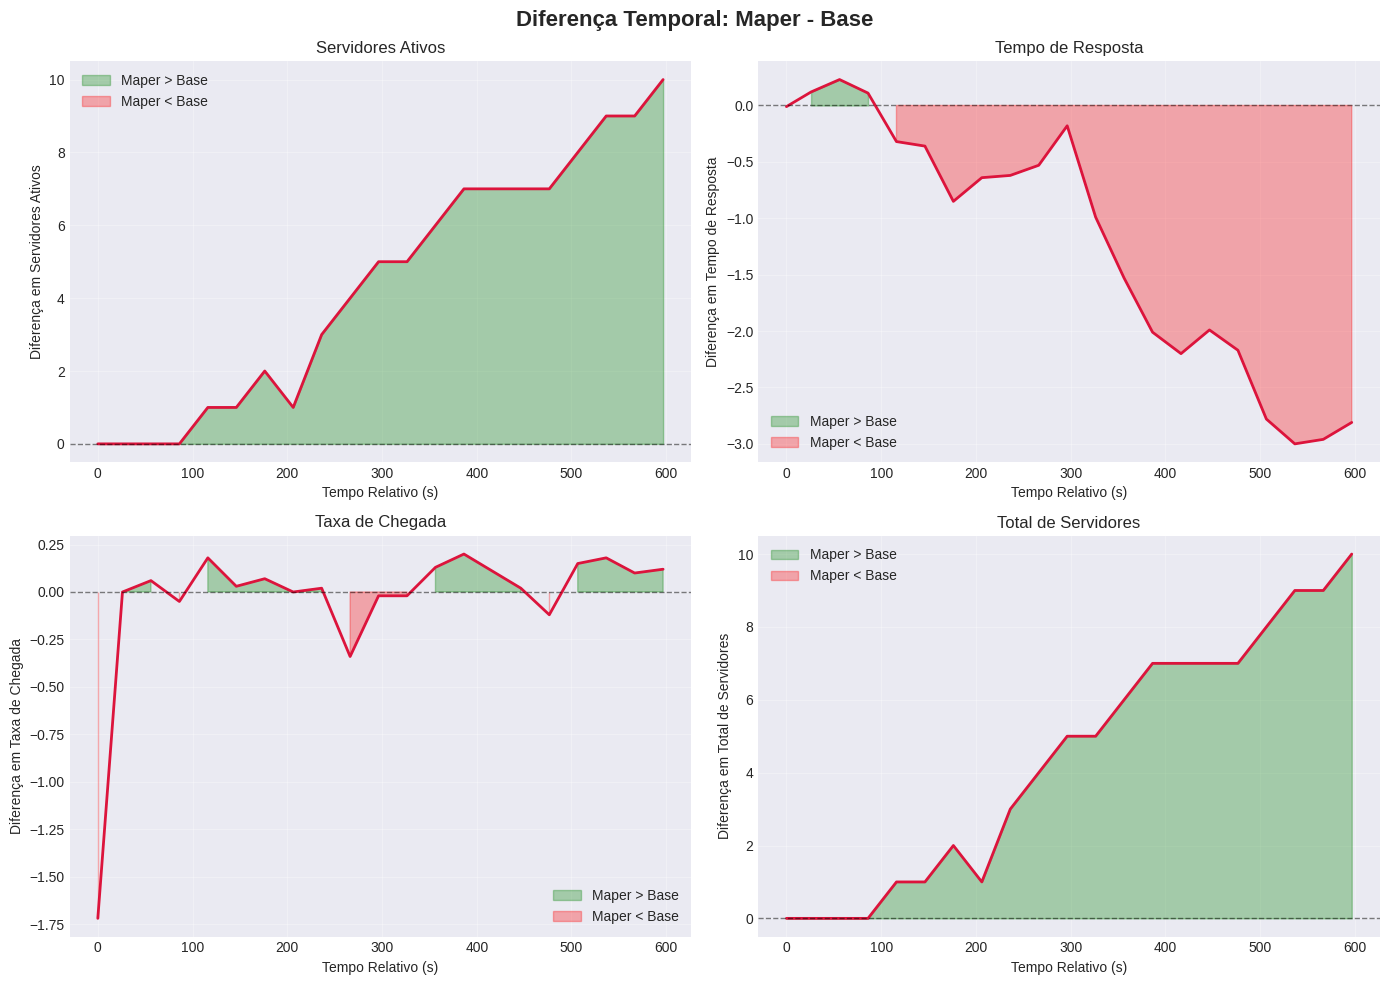

In [1204]:

fig2 = grafico_diferenca_temporal(df_base, df_maper)
# plt.savefig('diferenca_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

In [1205]:
def grafico_tempo_resposta(df_base, df_maper):
    """
    Cria gráfico individual comparando tempo de resposta
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Configurar cores mais vibrantes
    colors = ['#2E86AB', '#A23B72']
    
    # Plot com estilo melhorado
    ax.plot(df_base['time_relative'], df_base['response_time'], 
            label='Base', marker='o', linewidth=3, markersize=7, 
            color=colors[0], alpha=0.8, markeredgewidth=1.5, markeredgecolor='white')
    ax.plot(df_maper['time_relative'], df_maper['response_time'], 
            label='Maper', marker='s', linewidth=3, markersize=7, 
            color=colors[1], alpha=0.8, markeredgewidth=1.5, markeredgecolor='white')
    
    # Eixos e títulos com fontes maiores
    ax.set_xlabel('Execution time (s)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Response time (s)', fontsize=16, fontweight='bold')
    
    # Aumentar tamanho dos números nos eixos
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Legenda maior e com borda
    ax.legend(fontsize=14, frameon=True, shadow=True, fancybox=True, 
              loc='best', borderpad=1, framealpha=0.95)
    
    # Grid mais suave
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Fundo levemente colorido
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Adicionar borda ao gráfico
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    return fig

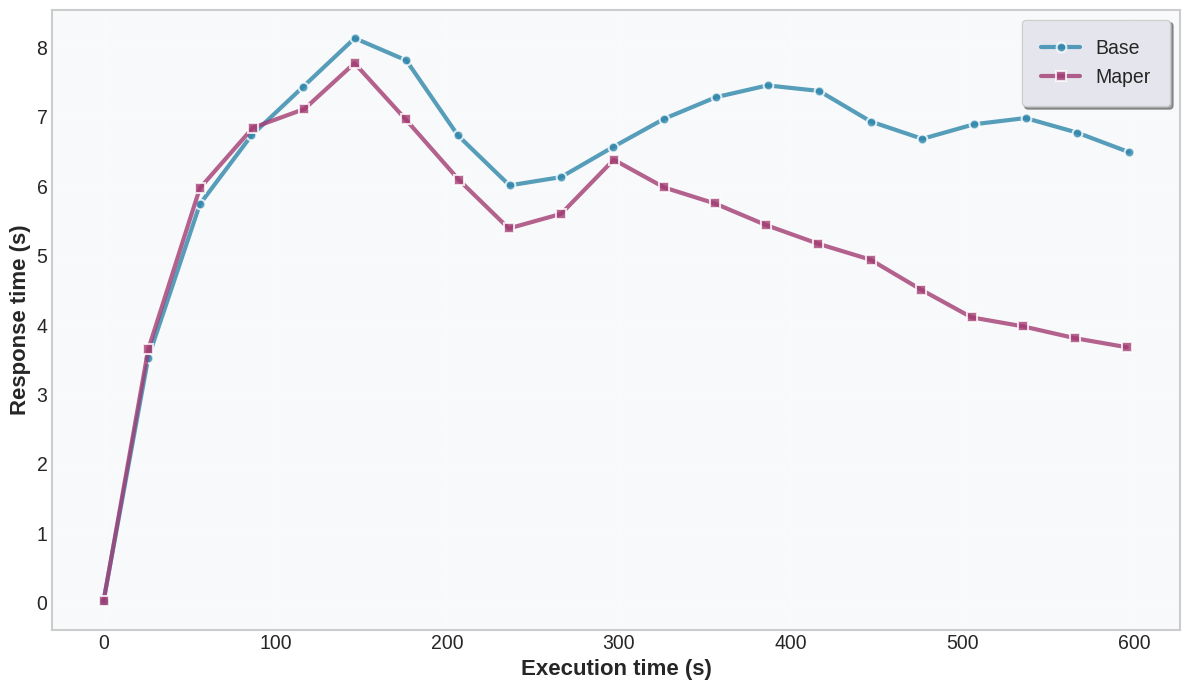

In [1206]:
fig = grafico_tempo_resposta(df_base, df_maper)
plt.show()

# Ou salvar
#plt.savefig('response_time.pdf', dpi=300, bbox_inches='tight')

In [1207]:
def calcular_arrival_rate_acumulado(df):
    """
    Calcula arrival_rate acumulado sem modificar o DataFrame original
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame com coluna 'arrival_rate'
    
    Returns:
    --------
    pandas.DataFrame
        Cópia do DataFrame com nova coluna 'arrival_rate_cumulative'
    """
    df_copy = df.copy()
    df_copy['arrival_rate_cumulative'] = df_copy['arrival_rate'].cumsum()
    return df_copy


In [1208]:
df_base = calcular_arrival_rate_acumulado(df_base)
df_maper= calcular_arrival_rate_acumulado(df_maper)


In [1209]:
def grafico_ar_resposta(df_base, df_maper):
    """
    Cria gráfico individual comparando tempo de resposta
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Configurar cores mais vibrantes
    colors = ['#2E86AB', '#A23B72']
    
    # Plot com estilo melhorado
    ax.plot(df_base['arrival_rate_cumulative'], df_base['response_time'], 
            label='Base', marker='o', linewidth=3, markersize=7, 
            color=colors[0], alpha=0.8, markeredgewidth=1.5, markeredgecolor='white')
    ax.plot(df_maper['arrival_rate_cumulative'], df_maper['response_time'], 
            label='Maper', marker='s', linewidth=3, markersize=7, 
            color=colors[1], alpha=0.8, markeredgewidth=1.5, markeredgecolor='white')
    
    # Eixos e títulos com fontes maiores
    ax.set_xlabel('Requisitions', fontsize=16, fontweight='bold')
    ax.set_ylabel('Response time (s)', fontsize=16, fontweight='bold')
    
    # Aumentar tamanho dos números nos eixos
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Legenda maior e com borda
    ax.legend(fontsize=14, frameon=True, shadow=True, fancybox=True, 
              loc='best', borderpad=1, framealpha=0.95)
    
    # Grid mais suave
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Fundo levemente colorido
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Adicionar borda ao gráfico
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    return fig

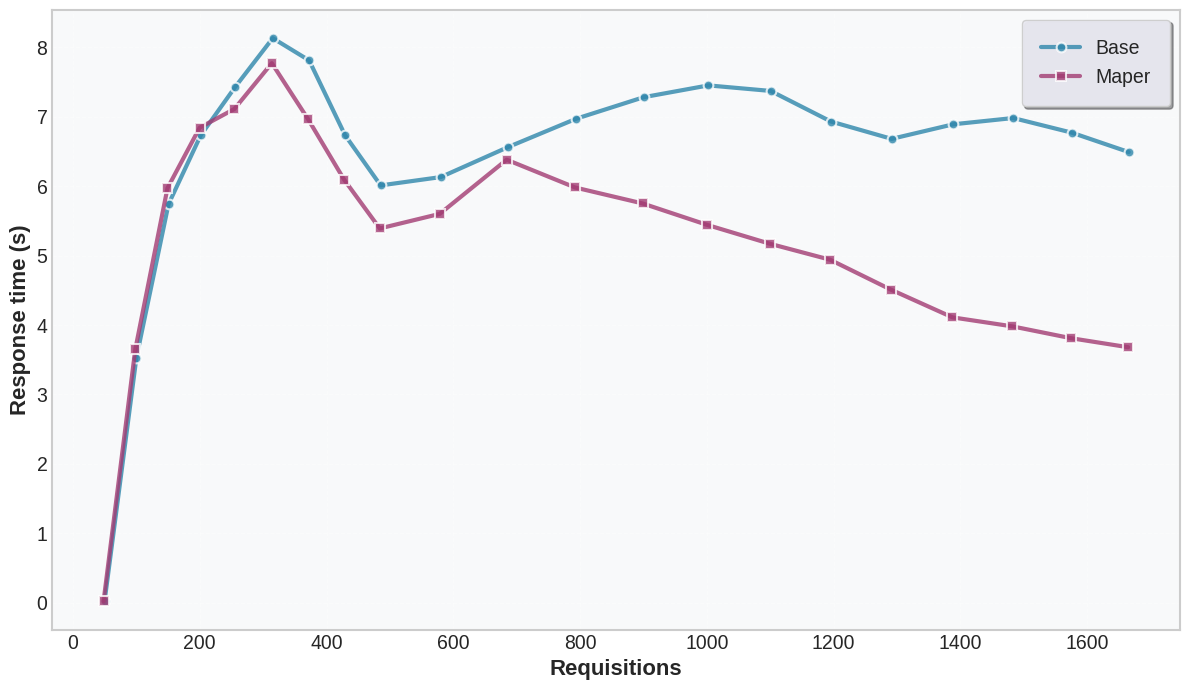

In [1210]:

fig = grafico_ar_resposta(df_base, df_maper)
plt.show()

In [1211]:
def adicionar_metricas_derivadas(df):
    """
    Adiciona múltiplas métricas calculadas a partir de arrival_rate e time_relative
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame com colunas 'arrival_rate' e 'time_relative'
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame com novas colunas de métricas derivadas
    """
    df_result = df.copy()
    
    # 1. REQUISIÇÕES ACUMULADAS (Total de requisições até o momento)
    # Calcula o intervalo de tempo entre medições
    df_result['time_interval'] = df_result['time_relative'].diff().fillna(df_result['time_relative'].iloc[0])
    
    # Requisições naquele intervalo = arrival_rate * tempo
    df_result['requests_in_interval'] = df_result['arrival_rate'] * df_result['time_interval']
    
    # Total acumulado de requisições
    df_result['total_requests_cumulative'] = df_result['requests_in_interval'].cumsum()
    
    
    # 2. ARRIVAL RATE MÉDIO ATÉ O MOMENTO
    df_result['arrival_rate_avg_cumulative'] = (
        df_result['total_requests_cumulative'] / df_result['time_relative']
    )
    
    
    # 3. TAXA DE MUDANÇA DO ARRIVAL RATE (aceleração/desaceleração)
    df_result['arrival_rate_change'] = df_result['arrival_rate'].diff()
    df_result['arrival_rate_change_rate'] = df_result['arrival_rate_change'] / df_result['time_interval']
    
    
    # 4. ARRIVAL RATE NORMALIZADO (em relação ao máximo)
    df_result['arrival_rate_normalized'] = (
        df_result['arrival_rate'] / df_result['arrival_rate'].max()
    )
    
    
    # 5. CARGA ACUMULADA (produto de arrival_rate * tempo)
    df_result['cumulative_load'] = (
        df_result['arrival_rate'] * df_result['time_relative']
    ).cumsum()
    
    
    # 6. MÉDIA MÓVEL DO ARRIVAL RATE (suaviza variações)
    window_size = 3
    df_result['arrival_rate_moving_avg'] = (
        df_result['arrival_rate'].rolling(window=window_size, min_periods=1).mean()
    )
    
    
    # 7. DESVIO DO ARRIVAL RATE MÉDIO
    overall_avg = df_result['arrival_rate'].mean()
    df_result['arrival_rate_deviation'] = df_result['arrival_rate'] - overall_avg
    df_result['arrival_rate_deviation_pct'] = (
        (df_result['arrival_rate'] - overall_avg) / overall_avg * 100
    )
    
    
    # 8. THROUGHPUT TEÓRICO (requisições processadas por segundo)
    # Se você tiver response_time, pode calcular:
    if 'response_time' in df_result.columns:
        df_result['theoretical_throughput'] = 1 / df_result['response_time']
        
        # Taxa de utilização (demanda vs capacidade)
        df_result['utilization'] = df_result['arrival_rate'] / df_result['theoretical_throughput']
        
        # Carga de trabalho (arrival_rate * response_time)
        df_result['workload'] = df_result['arrival_rate'] * df_result['response_time']
    
    
    # 9. DENSIDADE DE REQUISIÇÕES (requisições por unidade de tempo)
    df_result['request_density'] = df_result['requests_in_interval'] / df_result['time_interval']
    
    
    # 10. FATOR DE CRESCIMENTO
    df_result['growth_factor'] = df_result['arrival_rate'] / df_result['arrival_rate'].iloc[0]
    
    
    # Limpar colunas auxiliares se desejar
    # df_result = df_result.drop(['time_interval', 'requests_in_interval'], axis=1)
    
    return df_result


# Versão simplificada - apenas as métricas mais úteis
def adicionar_metricas_essenciais(df):
    """
    Adiciona apenas as métricas mais importantes e úteis
    """
    df_result = df.copy()
    
    # Calcular intervalo de tempo
    df_result['time_interval'] = df_result['time_relative'].diff().fillna(df_result['time_relative'].iloc[0])
    
    # 1. Total de requisições acumuladas
    df_result['requests_in_interval'] = df_result['arrival_rate'] * df_result['time_interval']
    df_result['total_requests'] = df_result['requests_in_interval'].cumsum()
    
    # 2. Taxa média de chegada até o momento
    df_result['avg_arrival_rate'] = df_result['total_requests'] / df_result['time_relative']
    
    # 3. Se tiver response_time, calcular utilização
    if 'response_time' in df_result.columns:
        df_result['workload'] = df_result['arrival_rate'] * df_result['response_time']
        df_result['workload_cumulative'] = df_result['workload'].cumsum()
    
    # 4. Taxa de mudança (derivada)
    df_result['arrival_rate_change'] = df_result['arrival_rate'].diff()
    
    return df_result


# Exemplo de uso com visualização
def visualizar_metricas_derivadas(df_original):
    """
    Cria visualizações das métricas derivadas
    """
    df = adicionar_metricas_essenciais(df_original)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Requisições Acumuladas
    ax1 = axes[0, 0]
    ax1.plot(df['time_relative'], df['total_requests'], 
             linewidth=3, marker='o', markersize=8, color='#D62828')
    ax1.set_xlabel('Time Relative (s)', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Total Requests', fontsize=16, fontweight='bold')
    ax1.set_title('Cumulative Requests Over Time', fontsize=18, fontweight='bold')
    ax1.grid(True, alpha=0.4)
    ax1.tick_params(labelsize=14)
    
    # 2. Arrival Rate vs Média Acumulada
    ax2 = axes[0, 1]
    ax2.plot(df['time_relative'], df['arrival_rate'], 
             linewidth=3, marker='o', markersize=8, 
             color='#023E8A', label='Instantaneous')
    ax2.plot(df['time_relative'], df['avg_arrival_rate'], 
             linewidth=3, linestyle='--', marker='s', markersize=8,
             color='#FFA500', label='Cumulative Average')
    ax2.set_xlabel('Time Relative (s)', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Arrival Rate', fontsize=16, fontweight='bold')
    ax2.set_title('Arrival Rate: Instant vs Average', fontsize=18, fontweight='bold')
    ax2.legend(fontsize=14)
    ax2.grid(True, alpha=0.4)
    ax2.tick_params(labelsize=14)
    
    # 3. Taxa de Mudança
    ax3 = axes[1, 0]
    colors = ['green' if x >= 0 else 'red' for x in df['arrival_rate_change']]
    ax3.bar(df['time_relative'], df['arrival_rate_change'], 
            color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=2)
    ax3.set_xlabel('Time Relative (s)', fontsize=16, fontweight='bold')
    ax3.set_ylabel('Arrival Rate Change', fontsize=16, fontweight='bold')
    ax3.set_title('Rate of Change in Arrival Rate', fontsize=18, fontweight='bold')
    ax3.grid(True, alpha=0.4, axis='y')
    ax3.tick_params(labelsize=14)
    
    # 4. Workload (se disponível)
    ax4 = axes[1, 1]
    if 'workload' in df.columns:
        ax4.fill_between(df['time_relative'], df['workload'], 
                        alpha=0.5, color='#9B59B6')
        ax4.plot(df['time_relative'], df['workload'], 
                linewidth=3, marker='o', markersize=8, color='#6A1B9A')
        ax4.set_xlabel('Time Relative (s)', fontsize=16, fontweight='bold')
        ax4.set_ylabel('Workload (AR × RT)', fontsize=16, fontweight='bold')
        ax4.set_title('System Workload Over Time', fontsize=18, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Workload requires\nresponse_time column', 
                ha='center', va='center', fontsize=16, transform=ax4.transAxes)
        ax4.set_title('System Workload Over Time', fontsize=18, fontweight='bold')
    ax4.grid(True, alpha=0.4)
    ax4.tick_params(labelsize=14)
    
    plt.tight_layout()
    return fig, df


# Exemplo de uso:
df_com_metricas = adicionar_metricas_essenciais(df_base)
# print(df_com_metricas[['time_relative', 'arrival_rate', 'total_requests', 
#                        'avg_arrival_rate', 'arrival_rate_change']].head(10))

# fig, df_result = visualizar_metricas_derivadas(df_base)
# plt.savefig('metricas_derivadas.pdf', dpi=300, bbox_inches='tight')
# plt.show()

In [1212]:
df_com_metricas

,time_relative,response_time,active_servers,dimmer,arrival_rate,total_servers,diagnosis,plans,human_calls,arrival_rate_cumulative,time_interval,requests_in_interval,total_requests,avg_arrival_rate,workload,workload_cumulative,arrival_rate_change
0,0.000,0.03,3,0.9,49.89,3,{'raw': 'decrease_servers'},{'decrease_servers_plan': {'entry': 'decrease_...,False,49.89,0.000,0.00000,0.00000,NaN,1.4967,1.4967,NaN
1,26.034,3.53,2,0.9,50.11,2,{'raw': 'increase_servers'},{'increase_servers_plan': {'entry': 'increase_...,False,100.00,26.034,1304.56374,1304.56374,50.110000,176.8883,178.3850,0.22
2,56.076,5.74,3,0.9,50.69,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,150.69,30.042,1522.82898,2827.39272,50.420728,290.9606,469.3456,0.58
3,86.110,6.73,3,0.9,50.75,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,201.44,30.034,1524.22550,4351.61822,50.535573,341.5475,810.8931,0.06
4,116.145,7.43,3,0.9,54.62,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,256.06,30.035,1640.51170,5992.12992,51.591803,405.8266,1216.7197,3.87
5,146.182,8.13,3,0.9,59.08,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,315.14,30.037,1774.58596,7766.71588,53.130453,480.3204,1697.0401,4.46
6,176.215,7.81,3,0.9,57.42,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,372.56,30.033,1724.49486,9491.21074,53.861537,448.4502,2145.4903,-1.66
7,206.252,6.73,3,0.9,56.84,3,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,429.40,30.037,1707.30308,11198.51382,54.295298,382.5332,2528.0235,-0.58
8,236.288,6.01,2,0.9,55.99,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,485.39,30.036,1681.71564,12880.22946,54.510722,336.4999,2864.5234,-0.85
9,266.324,6.13,2,0.9,94.96,2,{'raw': 'call_human'},{'danger': {'action': ['call_human']}}\n,True,580.35,30.036,2852.21856,15732.44802,59.072588,582.1048,3446.6282,38.97


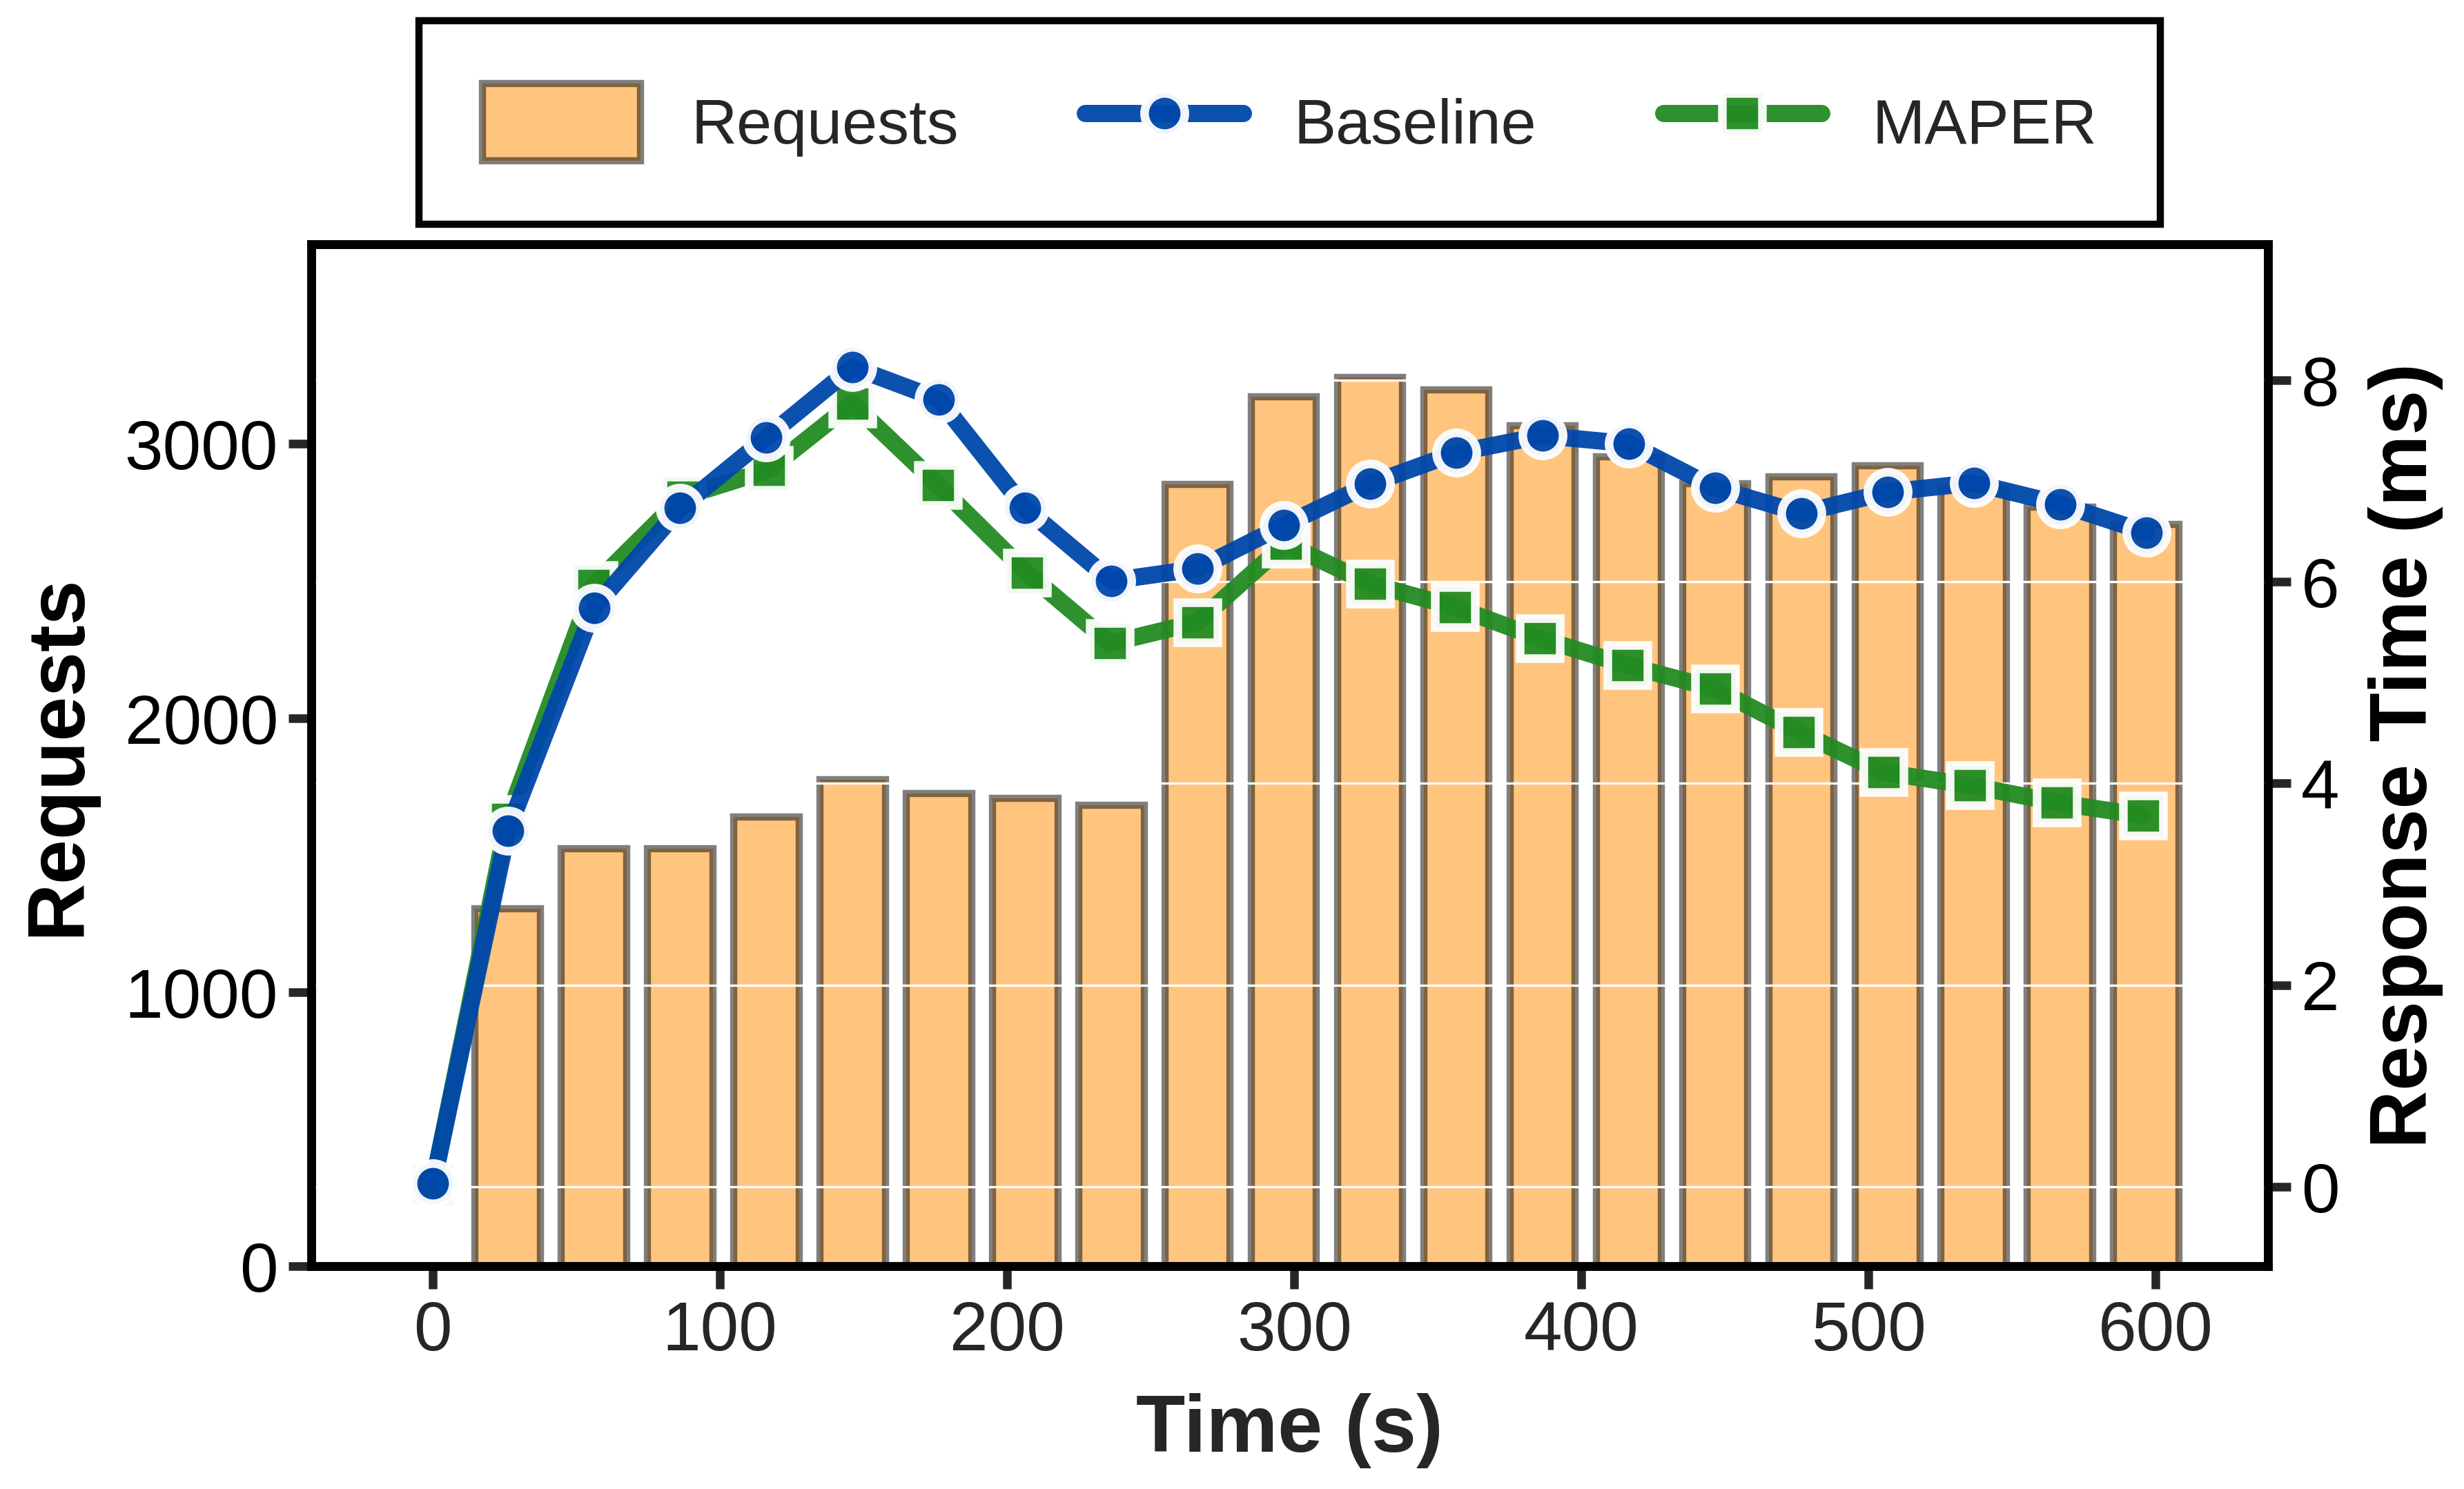

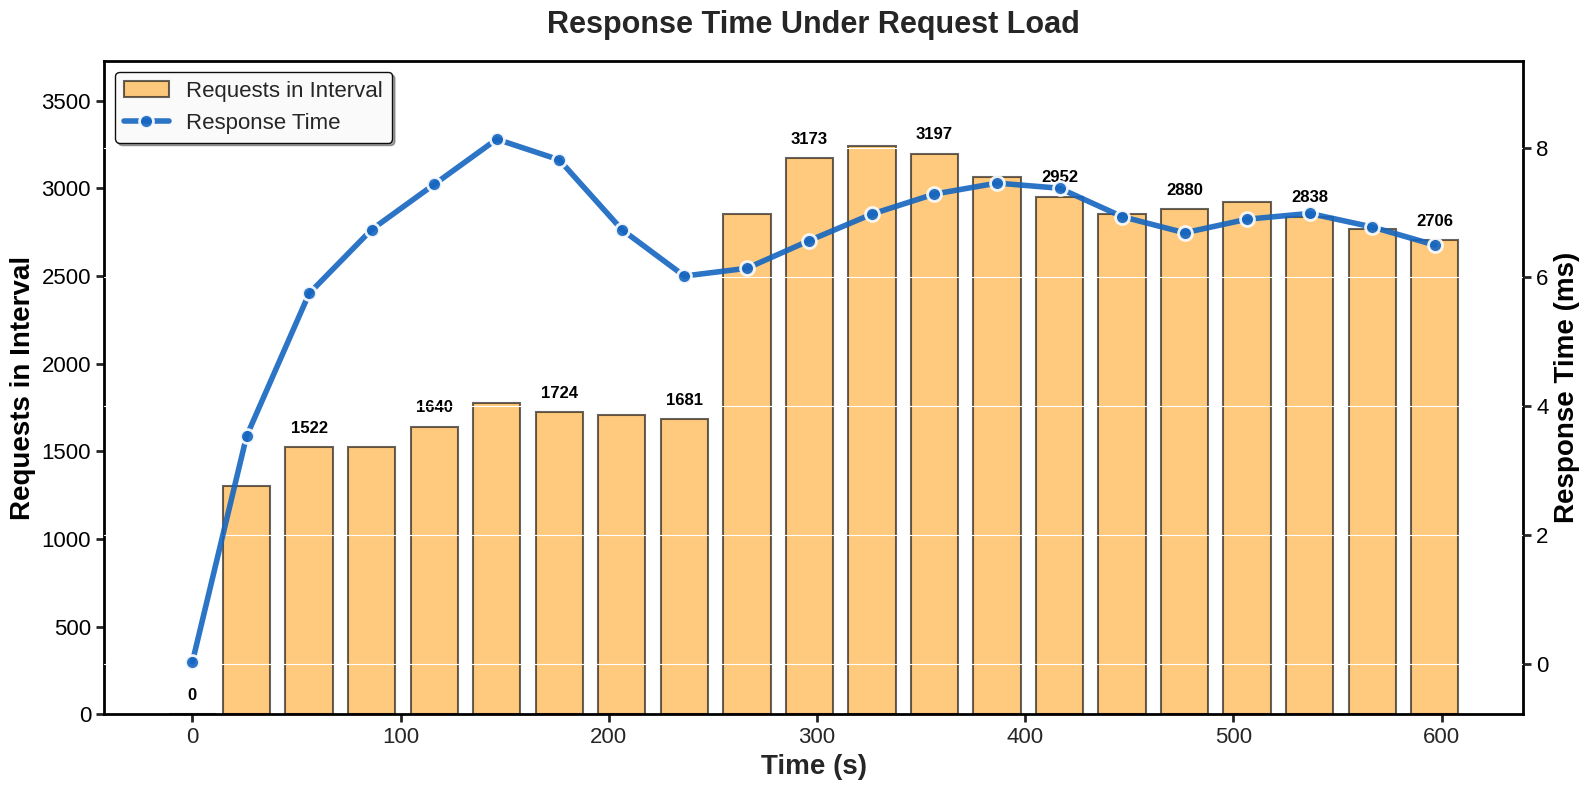

In [1213]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def grafico_rt_requests_tempo(df_base, df_maper):
    """
    Cria gráfico otimizado para artigo científico: elementos grandes e visíveis
    quando reduzido. Barras (requests_in_interval) no fundo, linhas (response_time)
    na frente, eixo X = time_relative
    
    Parameters:
    -----------
    df_base : pandas.DataFrame
        DataFrame Baseline
    df_maper : pandas.DataFrame
        DataFrame MAPER
    """
    
    # Figura com proporção intermediária - nem muito larga, nem muito quadrada
    fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)
    
    # Cores mais contrastantes
    color_bar = '#FF8C00'  # Laranja mais escuro
    color_base = '#0047AB'  # Azul royal forte
    color_maper = '#228B22'  # Verde floresta forte
    
    # Calcular requests_in_interval se não existir
    if 'requests_in_interval' not in df_base.columns:
        df_base['time_interval'] = df_base['time_relative'].diff().fillna(df_base['time_relative'].iloc[0])
        df_base['requests_in_interval'] = df_base['arrival_rate'] * df_base['time_interval']
    if 'requests_in_interval' not in df_maper.columns:
        df_maper['time_interval'] = df_maper['time_relative'].diff().fillna(df_maper['time_relative'].iloc[0])
        df_maper['requests_in_interval'] = df_maper['arrival_rate'] * df_maper['time_interval']
    
    bar_width = df_base['time_relative'].diff().fillna(df_base['time_relative'].iloc[0]).mean() * 0.8
    
    # BARRAS: Requests in Interval (eixo Y esquerdo) - bordas mais grossas
    bars = ax1.bar(df_base['time_relative'], df_base['requests_in_interval'], 
                   width=bar_width, color=color_bar, alpha=0.5, 
                   edgecolor='black', linewidth=2.5, label='Requests', zorder=1)
    
    # Eixo X e Y esquerdo - FONTES MUITO MAIORES
    ax1.set_xlabel('Time (s)', fontsize=28, fontweight='bold', labelpad=10)
    ax1.set_ylabel('Requests', fontsize=28, fontweight='bold', color='black', labelpad=10)
    ax1.tick_params(axis='y', labelcolor='black', labelsize=24, width=3, length=8)
    ax1.tick_params(axis='x', labelsize=24, width=3, length=8)
    ax1.set_ylim(0, max(df_base['requests_in_interval']) * 1.15)
    
    # Grid mais visível
    ax1.grid(True, alpha=0.4, linestyle='--', linewidth=2, zorder=0)
    ax1.set_axisbelow(True)
    
    # SEGUNDO EIXO Y: Response Time
    ax2 = ax1.twinx()
    
    # LINHAS: Response Time - MUITO MAIS GROSSAS e marcadores MAIORES
    line2 = ax2.plot(df_maper['time_relative'], df_maper['response_time'], 
                     's-', linewidth=6, markersize=14, color=color_maper, 
                     alpha=0.95, markeredgewidth=3, markeredgecolor='white',
                     label='MAPER', zorder=3)
    
    line1 = ax2.plot(df_base['time_relative'], df_base['response_time'], 
                     'o-', linewidth=6, markersize=14, color=color_base, 
                     alpha=0.95, markeredgewidth=3, markeredgecolor='white',
                     label='Baseline', zorder=3)
    
    
    # Eixo Y direito - FONTES MUITO MAIORES
    ax2.set_ylabel('Response Time (ms)', fontsize=28, fontweight='bold', 
                   color='black', labelpad=10)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=24, width=3, length=8)
    
    # Ajustar limites do eixo Y direito
    rt_min = min(df_base['response_time'].min(), df_maper['response_time'].min())
    rt_max = max(df_base['response_time'].max(), df_maper['response_time'].max())
    rt_range = rt_max - rt_min
    ax2.set_ylim(rt_min - rt_range * 0.1, rt_max + rt_range * 0.15)
    
    # Legenda MAIOR - posicionada FORA do gráfico, acima no centro
    lines_labels = [bars] + line1 + line2
    labels = ['Requests', 'Baseline', 'MAPER']
    
    legend = ax1.legend(lines_labels, labels, fontsize=22, 
                       loc='upper center', bbox_to_anchor=(0.5, 1.25),
                       ncol=3, frameon=True, shadow=False, 
                       fancybox=False, framealpha=0.98, edgecolor='black', 
                       facecolor='white', borderpad=1, labelspacing=0.8, 
                       handlelength=2.5, handleheight=1.5, columnspacing=2)
    legend.get_frame().set_linewidth(2.5)
    
    # Bordas MAIS GROSSAS
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(3)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(3)
    
    # Fundo branco
    ax1.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Ajustar layout para acomodar a legenda acima
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig

# Exemplo de uso:

# Comparando duas tabelas
fig = grafico_rt_requests_tempo(df_base, df_maper)
plt.savefig('rt_requests_tempo_comparacao.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Ou apenas uma tabela
fig = grafico_rt_requests_tempo_simples(df_base)
#plt.savefig('rt_requests_tempo_single.pdf', dpi=300, bbox_inches='tight')
plt.show()
